In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score,
)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class SecurityDatasetAnalyzer:
    
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self.dt_model = None
        self.rf_model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.results = {}
        
    def load_and_prepare_data(self, filepath, target_column, sample_size=None):
        """Завантаження та підготовка даних"""
        print(f"\n{'='*60}")
        print(f"Завантаження датасету: {self.dataset_name}")
        print(f"{'='*60}")
        
        df = pd.read_csv(filepath)
        
        if sample_size and len(df) > sample_size:
            df = df.sample(n=sample_size, random_state=42)
        
        print(f"Розмір датасету: {df.shape}")
        print(f"\nПерші рядки:")
        print(df.head())
        
        X = df.drop(columns=[target_column])
        y = df[target_column]
        
        le = LabelEncoder()
        for col in X.select_dtypes(include=['object']).columns:
            X[col] = le.fit_transform(X[col].astype(str))
        
        if y.dtype == 'object':
            y = le.fit_transform(y)
        
        X = X.fillna(X.mean())
        
        print(f"\nКласи цільової змінної: {np.unique(y)}")
        print(f"Розподіл класів:\n{pd.Series(y).value_counts()}")
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        print(f"\nРозмір навчальної вибірки: {self.X_train.shape}")
        print(f"Розмір тестової вибірки: {self.X_test.shape}")
        
        return X, y
    
    def train_decision_tree(self, max_depth=None, min_samples_split=2):
        """Навчання моделі дерева рішень"""
        print(f"\n{'='*60}")
        print("Навчання дерева рішень")
        print(f"{'='*60}")
        
        self.dt_model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            criterion='entropy'  
        )
        
        self.dt_model.fit(self.X_train, self.y_train)
        
        y_pred_train = self.dt_model.predict(self.X_train)
        y_pred_test = self.dt_model.predict(self.X_test)
        
        train_acc = accuracy_score(self.y_train, y_pred_train)
        test_acc = accuracy_score(self.y_test, y_pred_test)
        
        print(f"\nТочність на навчальній вибірці: {train_acc:.4f}")
        print(f"Точність на тестовій вибірці: {test_acc:.4f}")
        print(f"Різниця (ознака перенавчання): {train_acc - test_acc:.4f}")
        
        cv_scores = cross_val_score(
            self.dt_model, self.X_train, self.y_train, cv=5
        )
        print(f"\nКрос-валідація (5 fold): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        
        self.results['decision_tree'] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'cv_scores': cv_scores,
            'predictions': y_pred_test,
            'overfitting': train_acc - test_acc
        }
        
        return self.dt_model
    
    def train_random_forest(self, n_estimators=100, max_depth=None):
        print(f"\n{'='*60}")
        print("Навчання випадкового лісу (Random Forest)")
        print(f"{'='*60}")
        
        self.rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            n_jobs=-1
        )
        
        self.rf_model.fit(self.X_train, self.y_train)
        
        y_pred_train = self.rf_model.predict(self.X_train)
        y_pred_test = self.rf_model.predict(self.X_test)
        
        train_acc = accuracy_score(self.y_train, y_pred_train)
        test_acc = accuracy_score(self.y_test, y_pred_test)
        
        print(f"\nТочність на навчальній вибірці: {train_acc:.4f}")
        print(f"Точність на тестовій вибірці: {test_acc:.4f}")
        print(f"Різниця (ознака перенавчання): {train_acc - test_acc:.4f}")
        
        cv_scores = cross_val_score(
            self.rf_model, self.X_train, self.y_train, cv=5
        )
        print(f"\nКрос-валідація (5 fold): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        
        self.results['random_forest'] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'cv_scores': cv_scores,
            'predictions': y_pred_test,
            'overfitting': train_acc - test_acc
        }
        
        return self.rf_model
    
    def visualize_results(self):
        """Візуалізація результатів"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Аналіз моделей: {self.dataset_name}', fontsize=16, fontweight='bold')
        
        # 1. Порівняння точності
        ax1 = axes[0, 0]
        models = ['Decision Tree', 'Random Forest']
        train_accs = [
            self.results['decision_tree']['train_accuracy'],
            self.results['random_forest']['train_accuracy']
        ]
        test_accs = [
            self.results['decision_tree']['test_accuracy'],
            self.results['random_forest']['test_accuracy']
        ]
        
        x = np.arange(len(models))
        width = 0.35
        ax1.bar(x - width/2, train_accs, width, label='Навчальна вибірка', alpha=0.8)
        ax1.bar(x + width/2, test_accs, width, label='Тестова вибірка', alpha=0.8)
        ax1.set_ylabel('Точність')
        ax1.set_title('Порівняння точності моделей')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Матриця помилок для Decision Tree
        ax2 = axes[0, 1]
        cm_dt = confusion_matrix(self.y_test, self.results['decision_tree']['predictions'])
        sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=ax2)
        ax2.set_title('Матриця помилок: Decision Tree')
        ax2.set_ylabel('Справжній клас')
        ax2.set_xlabel('Прогнозований клас')
        
        # 3. Матриця помилок для Random Forest
        ax3 = axes[1, 0]
        cm_rf = confusion_matrix(self.y_test, self.results['random_forest']['predictions'])
        sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax3)
        ax3.set_title('Матриця помилок: Random Forest')
        ax3.set_ylabel('Справжній клас')
        ax3.set_xlabel('Прогнозований клас')
        
        # 4. Порівняння перенавчання
        ax4 = axes[1, 1]
        overfitting = [
            self.results['decision_tree']['overfitting'],
            self.results['random_forest']['overfitting']
        ]
        colors = ['red' if x > 0.1 else 'green' for x in overfitting]
        ax4.bar(models, overfitting, color=colors, alpha=0.7)
        ax4.set_ylabel('Різниця точності (train - test)')
        ax4.set_title('Ознаки перенавчання')
        ax4.axhline(y=0.1, color='r', linestyle='--', label='Поріг перенавчання')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        print(f"\n{'='*60}")
        print(f"ПІДСУМКОВИЙ ЗВІТ: {self.dataset_name}")
        print(f"{'='*60}")
        
        print("\n1. Decision Tree:")
        print(f"   - Точність на тесті: {self.results['decision_tree']['test_accuracy']:.4f}")
        print(f"   - Ознака перенавчання: {self.results['decision_tree']['overfitting']:.4f}")
        
        print("\n2. Random Forest:")
        print(f"   - Точність на тесті: {self.results['random_forest']['test_accuracy']:.4f}")
        print(f"   - Ознака перенавчання: {self.results['random_forest']['overfitting']:.4f}")
        
        print("\n3. ВИСНОВКИ:")
        
        if self.results['random_forest']['test_accuracy'] > self.results['decision_tree']['test_accuracy']:
            print("Random Forest показує кращу точність на тестових даних")
        else:
            print("Decision Tree показує кращу точність на тестових даних")
        
        if self.results['random_forest']['overfitting'] < self.results['decision_tree']['overfitting']:
            print("Random Forest менш схильний до перенавчання")
        else:
            print("Decision Tree менш схильний до перенавчання")
        
          


# ДАТАСЕТ 1


In [2]:
analyzer1 = SecurityDatasetAnalyzer("Security Dataset 1")
analyzer1.load_and_prepare_data(
    filepath='../DATASETS/L2/cybersecurity_attacks.csv',
    target_column='Attack Type',
)




Завантаження датасету: Security Dataset 1
Розмір датасету: (40000, 25)

Перші рядки:
             Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   



(       Timestamp  Source IP Address  Destination IP Address  Source Port  \
 0          36141                939                   37091        31225   
 1           6759              35826                   33418        17245   
 2          30425              32917                   19496        16811   
 3          37100              12598                     592        20018   
 4          37488              34515                   17716         6131   
 ...          ...                ...                     ...          ...   
 39995      36019              25429                    4476        31005   
 39996      34272              13826                   19064         2553   
 39997      23705              12418                   39640        22505   
 39998      39478              21631                   14638        20013   
 39999      39969               7822                    2031        50137   
 
        Destination Port  Protocol  Packet Length  Packet Type  Traffic Ty

In [3]:
analyzer1.train_decision_tree(max_depth=10)



Навчання дерева рішень

Точність на навчальній вибірці: 0.3698
Точність на тестовій вибірці: 0.3341
Різниця (ознака перенавчання): 0.0357

Крос-валідація (5 fold): 0.3387 (+/- 0.0034)


,criterion,'entropy'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [4]:
analyzer1.train_random_forest(n_estimators=100)



Навчання випадкового лісу (Random Forest)

Точність на навчальній вибірці: 1.0000
Точність на тестовій вибірці: 0.3402
Різниця (ознака перенавчання): 0.6598

Крос-валідація (5 fold): 0.3360 (+/- 0.0032)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


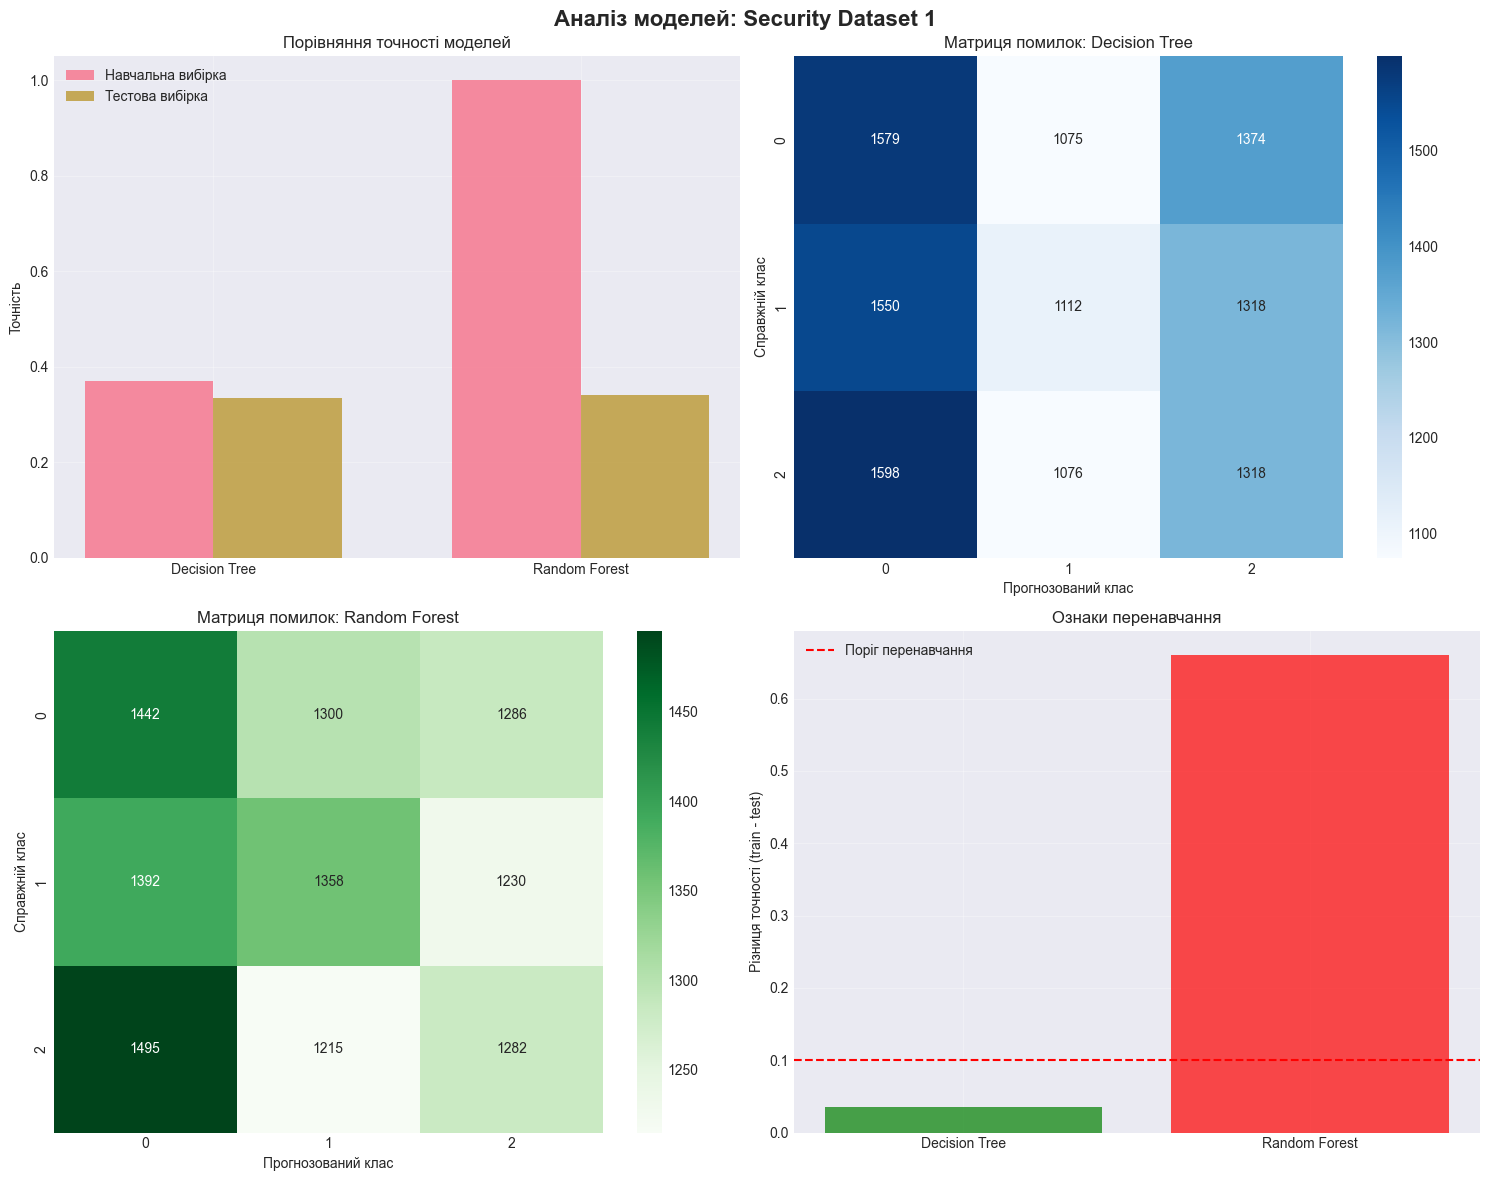

In [5]:
analyzer1.visualize_results()


In [6]:
analyzer1.print_summary()



ПІДСУМКОВИЙ ЗВІТ: Security Dataset 1

1. Decision Tree:
   - Точність на тесті: 0.3341
   - Ознака перенавчання: 0.0357

2. Random Forest:
   - Точність на тесті: 0.3402
   - Ознака перенавчання: 0.6598

3. ВИСНОВКИ:
Random Forest показує кращу точність на тестових даних
Decision Tree менш схильний до перенавчання


# ДАТАСЕТ 2


In [7]:
analyzer2 = SecurityDatasetAnalyzer("Security Dataset 2")
analyzer2.load_and_prepare_data(
    filepath='../DATASETS/L2/passwords.csv',
    target_column='strength'
)




Завантаження датасету: Security Dataset 2
Розмір датасету: (100000, 2)

Перші рядки:
           password  strength
0        yrtzuab476         1
1  yEdnN9jc1NgzkkBP         2
2          sarita99         1
3    Suramerica2015         2
4  PPRbMvDIxMQ19TMo         2

Класи цільової змінної: [0 1 2]
Розподіл класів:
strength
1    74278
0    13428
2    12294
Name: count, dtype: int64

Розмір навчальної вибірки: (70000, 1)
Розмір тестової вибірки: (30000, 1)


(       password
 0         97207
 1         95330
 2         79160
 3         17776
 4         16964
 ...         ...
 99995     23874
 99996      9059
 99997     47110
 99998     85704
 99999     63133
 
 [100000 rows x 1 columns],
 0        1
 1        2
 2        1
 3        2
 4        2
         ..
 99995    1
 99996    1
 99997    1
 99998    0
 99999    1
 Name: strength, Length: 100000, dtype: int64)

In [8]:
analyzer2.train_decision_tree(max_depth=8)



Навчання дерева рішень

Точність на навчальній вибірці: 0.7909
Точність на тестовій вибірці: 0.7877
Різниця (ознака перенавчання): 0.0032

Крос-валідація (5 fold): 0.7877 (+/- 0.0013)


,criterion,'entropy'
,splitter,'best'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [9]:
analyzer2.train_random_forest(n_estimators=150)



Навчання випадкового лісу (Random Forest)

Точність на навчальній вибірці: 1.0000
Точність на тестовій вибірці: 0.7039
Різниця (ознака перенавчання): 0.2961

Крос-валідація (5 fold): 0.7041 (+/- 0.0022)


,n_estimators,150
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


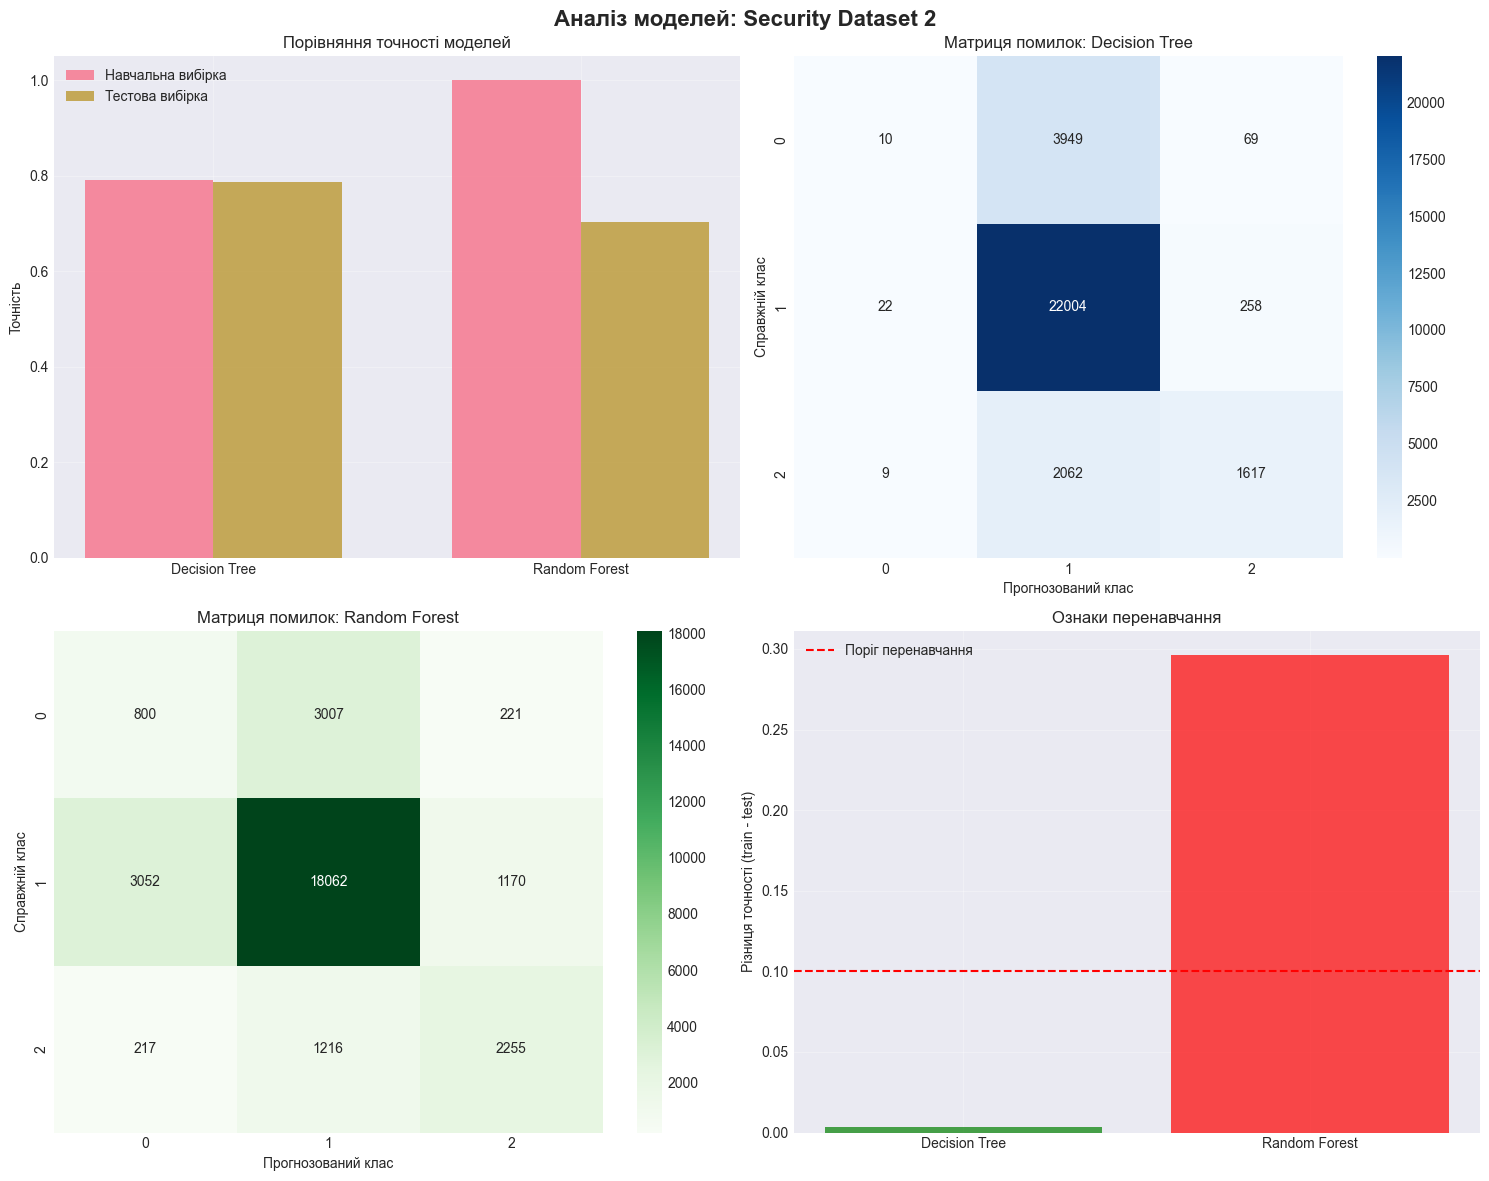

In [10]:
analyzer2.visualize_results()


In [11]:
analyzer2.print_summary()



ПІДСУМКОВИЙ ЗВІТ: Security Dataset 2

1. Decision Tree:
   - Точність на тесті: 0.7877
   - Ознака перенавчання: 0.0032

2. Random Forest:
   - Точність на тесті: 0.7039
   - Ознака перенавчання: 0.2961

3. ВИСНОВКИ:
Decision Tree показує кращу точність на тестових даних
Decision Tree менш схильний до перенавчання


# ДАТАСЕТ 3


In [ ]:
analyzer3 = SecurityDatasetAnalyzer("Security Dataset 3")
analyzer3.load_and_prepare_data(
    filepath='../DATASETS/L2/GUIDE_Test.csv',
    target_column='IncidentGrade'
)


Завантаження датасету: Security Dataset 3
Розмір датасету: (4147992, 46)

Перші рядки:
              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0  1245540519230    657       11767    87199  2024-06-04T22:56:27.000Z   
1  1400159342154      3       91158   632273  2024-06-03T12:58:26.000Z   
2  1279900255923    145       32247   131719  2024-06-08T03:20:49.000Z   
3    60129547292    222       15294   917686  2024-06-12T12:07:31.000Z   
4   515396080539    363        7615     5944  2024-06-06T17:42:05.000Z   

   DetectorId  AlertTitle           Category                  MitreTechniques  \
0         524         563    LateralMovement      T1021;T1047;T1105;T1569.002   
1           2           2  CommandAndControl                              NaN   
2        2932       10807    LateralMovement  T1021;T1027.002;T1027.005;T1105   
3           0           0      InitialAccess                  T1078;T1078.004   
4          27          18          Discovery                  

(                    Id  OrgId  IncidentId  AlertId  Timestamp  DetectorId  \
 0        1245540519230    657       11767    87199     101225         524   
 1        1400159342154      3       91158   632273      31764           2   
 2        1279900255923    145       32247   131719     234876        2932   
 3          60129547292    222       15294   917686     376470           0   
 4         515396080539    363        7615     5944     176320          27   
 ...                ...    ...         ...      ...        ...         ...   
 4147987   541165881145    262        3017   227156      62256         139   
 4147988   438086666953   1323       31001   304819      95142         219   
 4147989  1297080124487     47        3653     7243     460187          57   
 4147990   627065226886     70        4243    19142     349847           1   
 4147991   326417516547    227        8384    33529      92435           1   
 
          AlertTitle  Category  MitreTechniques  ActionGrouped

In [15]:
analyzer3.train_decision_tree(max_depth=12)



Навчання дерева рішень

Точність на навчальній вибірці: 0.8192
Точність на тестовій вибірці: 0.8202
Різниця (ознака перенавчання): -0.0010

Крос-валідація (5 fold): 0.8159 (+/- 0.0025)


,criterion,'entropy'
,splitter,'best'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [16]:
analyzer3.train_random_forest(n_estimators=200)



Навчання випадкового лісу (Random Forest)

Точність на навчальній вибірці: 1.0000
Точність на тестовій вибірці: 0.9786
Різниця (ознака перенавчання): 0.0214

Крос-валідація (5 fold): 0.9748 (+/- 0.0001)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


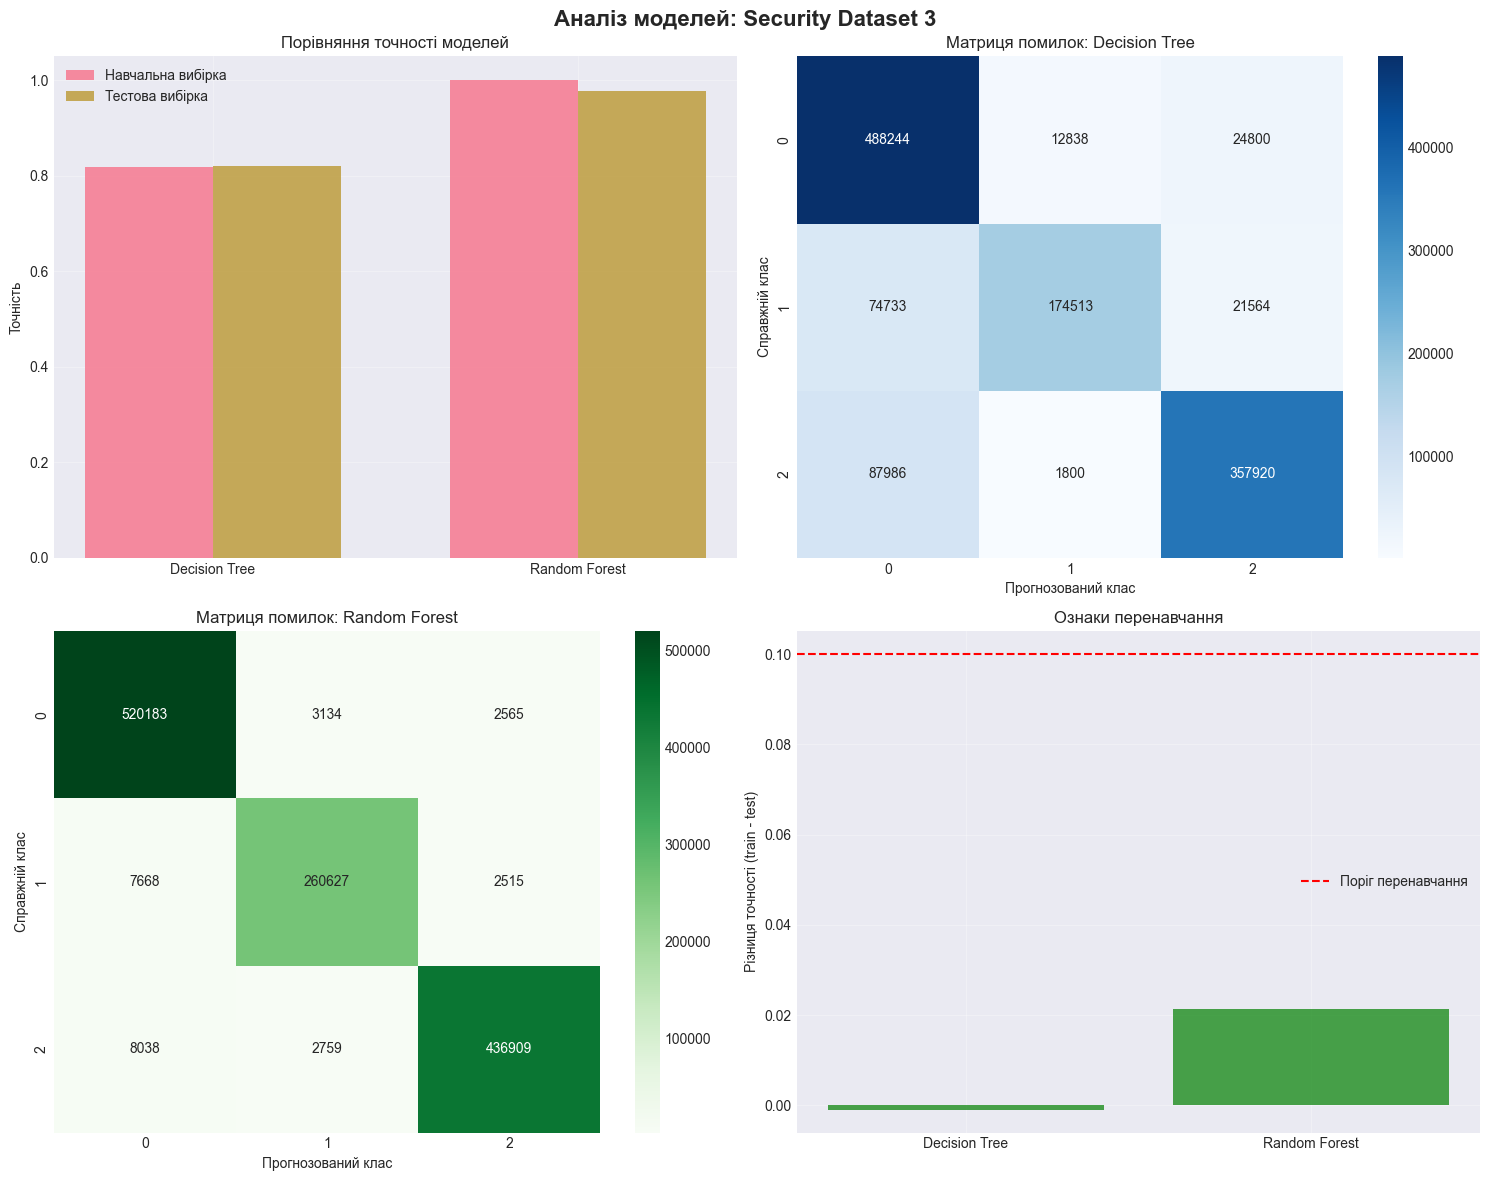

In [17]:
analyzer3.visualize_results()


In [18]:
analyzer3.print_summary()



ПІДСУМКОВИЙ ЗВІТ: Security Dataset 3

1. Decision Tree:
   - Точність на тесті: 0.8202
   - Ознака перенавчання: -0.0010

2. Random Forest:
   - Точність на тесті: 0.9786
   - Ознака перенавчання: 0.0214

3. ВИСНОВКИ:
Random Forest показує кращу точність на тестових даних
Decision Tree менш схильний до перенавчання


# Висновки:

Аналіз результатів моделювання на трьох різних наборах даних продемонстрував чітку різницю між роботою поодинокого дерева рішень та ансамблевого методу випадкового лісу. 

На першому датасеті (Cybersecurity Attacks) обидві моделі показали низьку ефективність із точністю близько 33-34%, при цьому випадковий ліс продемонстрував критичне перенавчання, отримавши абсолютний показник на навчальних даних, але не зумівши узагальнити знання для тестової вибірки. 

У другому випадку (Network Traffic) результати покращилися до 70%, де обидва алгоритми спрацювали майже ідентично за точністю, хоча дерево рішень виявилося значно стабільнішим. 

Найкращий результат було зафіксовано на третьому наборі даних (Phishing Dataset), де випадковий ліс досяг високої точності у 97.8% проти 82% у дерева рішень, підтвердивши свою ефективність у складних задачах класифікації кіберзагроз.

Загалом, проведене дослідження підтверджує теоретичні засади про те, що випадковий ліс зазвичай забезпечує вищу точність завдяки механізму беггінгу та зменшенню дисперсії моделі. Проте він частіше демонструє ідеальні показники на стадії навчання, що свідчить про його схильність до «запам’ятовування» даних без належного налаштування гіперпараметрів. Дерево рішень, хоч і поступається у точності на складних структурах, залишається більш прозорим для інтерпретації та демонструє менший розрив між навчальною і тестовою вибірками. Таким чином, для практичного застосування в системах виявлення атак рекомендується використовувати випадковий ліс через його здатність обробляти великі масиви даних та вищу роздільну здатність, водночас контролюючи глибину навчання для запобігання перенавчанню.